<a href="https://colab.research.google.com/github/hpbowala/Micrograd---Basic-Demo-of-Neural-Networks/blob/main/nnlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from graphviz import Digraph

In [4]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [5]:
class Value:
  def __init__(self,data,_children=(),_op="",label=""):
    self.data = data
    self.grad = 0.0
    self._backward = lambda : None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):

    out = Value(self.data + other.data, (self,other),'+')

    # self + other = out 
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward

    return out

  def __mul__(self,other):
    out = Value(self.data * other.data, (self,other), "*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t= (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value (t, (self, ), 'tanh')

    def _backward():
      self.grad = (1-t**2) * out.grad

    out._backward = _backward

    return out
    
      

In [6]:
a = Value(2.0)
b = Value(3.0)
d = Value(4.0)
c = a * b
e = d + c



a.label = 'a'
b.label = 'b'
c.label = 'c'
d.label = 'd'
e.label = 'e'

l = e.tanh()

l.label = 'l'


In [7]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'



In [8]:
# dy/dx = f(x+h) - f(x)/h  
# L = d*f
#L.grad = dL/df
# f((f+h)d) - f(d*f) / h
# = df + dh - df /h
# = dh/h
# = d
L.grad = 1.0

# f.grad = d
f.grad = 4
d.grad = -2

'''
d= e+c
dd/de
((e+h)+c) - (e+c)/h
h/h = 1
'''

'''
dL/de = dL/dd * dd/de
= -2 * 1
=-2
'''

e.grad = -2

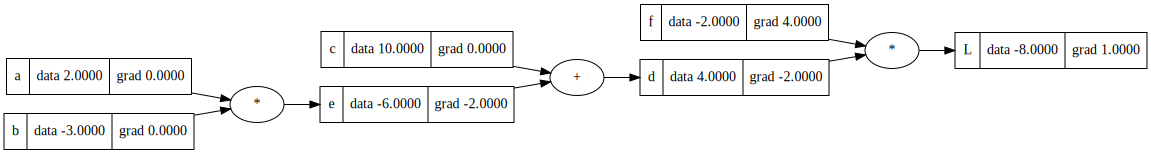

In [9]:
draw_dot(L)

In [10]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.84


In [11]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'





In [12]:
L.grad = 1
L._backward()
d._backward()
e._backward()

In [13]:
from types import BuiltinFunctionType
#using topological sort to call each backward functions 

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

build_topo(L)
L.grad = 1.0
for item in reversed(topo):
  item._backward()

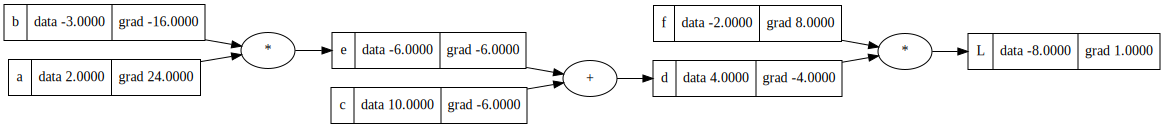

In [14]:
draw_dot(L)

In [15]:
class Value:
  def __init__(self,data,_children=(),_op="",label=""):
    self.data = data
    self.grad = 0.0
    self._backward = lambda : None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):

    out = Value(self.data + other.data, (self,other),'+')

    # self + other = out 
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward

    return out

  def __mul__(self,other):
    out = Value(self.data * other.data, (self,other), "*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t= (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value (t, (self, ), 'tanh')

    def _backward():
      self.grad = (1-t**2) * out.grad

    out._backward = _backward

    return out
    
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    self.grad = 1.0
    for item in reversed(topo):
      item._backward()

      

In [16]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'

In [17]:
L.backward()

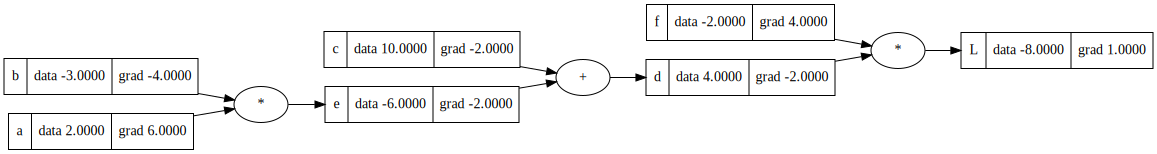

In [18]:
draw_dot(L)

In [19]:
# Modifying the Finalized Value object with 

In [20]:
#refactoring the Value object to do more additional math operations such as expo, power, substtraction  ---
class Value:
  def __init__(self, data, _children = (), _op='', label = ''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda : None 

  #printing format
  def __repr__(self):
    return f"Value(data={self.data})"

  #addition function {Value Object + (Value Object or a number)}
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")
    
    def backward_fun():
        self.grad += 1.0 * out.grad
        other.grad += 1.0 * out.grad
    out._backward = backward_fun

    return out

  #substraction function {Value Object - (Value Object or a number)}
  def __sub__(self, other):
    return self + (-other)

  #substraction function {number - Value Object}
  def __rsub__(self, other):
    return self + (-other)

  #multiplication function {Value Object * (Value Object or a number)}
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*") 
    
    def backward_fun():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = backward_fun

    return out

  #reverse add function {number * Value Object}
  def __radd__(self, other): 
    return self + other

  #reverse multiplication function {number * Value Object}
  def __rmul__(self, other):
    return self * other

  #division function {(Value object or number) / (Value object or number)}
  '''
  x/y = x * (1/y) = x * y^(-1)
  '''
  def __truediv__(self, other):
    return self * other**-1

  #power function {Value object ^ number}
  def __pow__(self, other):
    assert isinstance(other, (int, float)) #allow only the int and float as other for power values
    out = Value(self.data ** other, (self, ), f'**{other}')

    def backward_fun():
      self.grad += (other * (self.data ** (other -1))) * out.grad
    out._backward = backward_fun

    return out;

  #tanh fumction on the current Value object
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def backward_fun():
        out.grad += 1.0
        self.grad += (1 - t**2) * out.grad 
    out._backward = backward_fun

    return out

  #exponential on the current value object
  def exp(self):
    out = Value(math.exp(self.data), (self,), 'exp')

    def backward_fun():
      self.grad += out.data * out.grad
    out._backward = backward_fun

    return out

  #triggering Backpropagation from the last node
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [21]:
import random

In [22]:
# Creating a neuron
class Neuron:

  def __init__(self,ninputs):
    self.weights = [Value(random.uniform(1, -1)) for i in range(ninputs) ]
    self.bias = Value(random.uniform(1,-1))

  def __call__(self,inputs):
    # calculating sum of weighted inputs + bias
    dotProduct = sum(w*x for x, w in zip(inputs, self.weights)) + self.bias
    return dotProduct.tanh()
    


In [23]:
d = Neuron(2)
x = [1,2]
d(x)

Value(data=0.18377613919604024)

In [24]:
# Creating a layer 
class Layer:

  # neuron_in_layer -> # of neurons in the layer 
  def __init__(self,ninputs, neuron_in_layer):
    self.neurons = [Neuron(ninputs) for i in range (neuron_in_layer)]

  def __call__(self,inputs):
    output = []
    for neuron in self.neurons:  
      output.append(neuron(inputs))
    return output[0] if len(output) == 1 else output 


In [25]:
# creating Multilayer Perceptron
class MLP:
  # nouts -> list of no of neurons in layers
  # ninputs -> no of inputs in input layer
  def __init__(self,ninputs,nouts):
    '''
    ninputs = 3
    nouts = [4,4,1]
    noinputs = [3,4,4]
    '''
    temp_layers = [ninputs] + nouts

    self.layers = [Layer(temp_layers[i],temp_layers[i+1]) for i in range(len(nouts))]

  def __call__(self,inputs):
    for layer in self.layers:
      inputs = layer(inputs)
    return inputs

In [26]:
mlp = MLP(3,[4,4,1])
mlp([1,6,7])

Value(data=-0.5362349687694961)

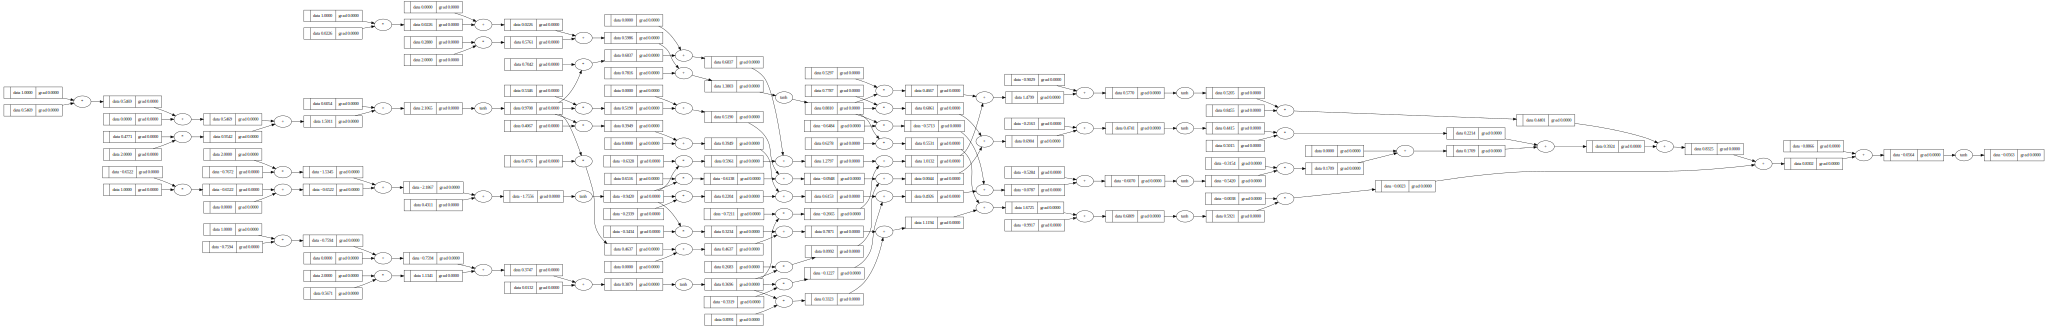

In [27]:
draw_dot(mlp(x))